<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/mbti/blob/master/MBTI_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **MBTI PREDICTIONS**
---

# **SOURCES AND DOCUMENTATION:**

---

**MBTI proyects:**
* [MBTI Personality Type Prediction Based on Text Analysis](https://donche.github.io/en/2017/12/27/mbti_blog.html)

* [Myers-Briggs personality type and financial risk tolerance prediction](https://github.com/bvannah/wellfie)

* [Predicting-Myers-Briggs-Type-Indicator-with-Recurrent-Neural-Networks](https://github.com/ianscottknight/Predicting-Myers-Briggs-Type-Indicator-with-Recurrent-Neural-Networks)

---

**Deep Leaning:**
* [Interpreting bag of words models with SHAP](https://sararobinson.dev/2019/04/23/interpret-bag-of-words-models-shap.html)

* [Productos de IA y aprendizaje automático](https://cloud.google.com/ml-engine/docs/python-client-library?hl=es-419)

* [Multi Class Text Classification with LSTM using TensorFlow 2.0!!!
](https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
)

---
**Natural Language Processing:**

* [Reducir el número de palabras de un texto: lematización y radicalización (stemming) con Python](https://medium.com/qu4nt/reducir-el-n%C3%BAmero-de-palabras-de-un-texto-lematizaci%C3%B3n-y-radicalizaci%C3%B3n-stemming-con-python-965bfd0c69fa)

* [Text Cleaning Methods for Natural Language Processing](https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7
)

* [Complete Guide to spaCy](https://nlpforhackers.io/complete-guide-to-spacy/)

* [Stemming and Lemmatization in Python](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

* [How to solve Spanish lemmatization problems with SpaCy?](https://stackoverflow.com/questions/60534999/how-to-solve-spanish-lemmatization-problems-with-spacy/60553026?noredirect=1#comment107164610_60553026)

* [stanfordnlp models](https://stanfordnlp.github.io/stanfordnlp/models.html)

---
# **1. MODULES**
---

**Tensorflow**

In [0]:
try:
  %tensorflow_version 2.x # specifying the TensorFlow version to google colab
except OSError:
  print('You are not using your specify version of TensorFlow')
finally:
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.preprocessing.text import Tokenizer # to preprocess using tokenizer
  from tensorflow.keras.preprocessing.sequence import pad_sequences # to pad sequences
  print(f'TF version: {tf.__version__}')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # specifying the TensorFlow version to google colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
TF version: 2.1.0


**Manipulation & preprocessing data libs**

In [0]:
# Manipulation
import pandas as pd # to dataset (csv) manipulation
import numpy as np # to array
from collections import Counter

import re # regular expressions

**Graphs libs**

In [0]:
import matplotlib.pyplot as plt # to create graphs

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

**Lemmatization: try downloads**

In [0]:
# Natural Language Preprocessing
# Stopwords
import nltk # Natural Language ToolKit
nltk.download('stopwords')
from nltk.corpus import stopwords # to get rid of StopWords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# SpaCy
!spacy download es_core_news_sm # sm md
import spacy
spNLP = spacy.load('es_core_news_sm') #sm md
activated = spacy.prefer_gpu()
spacy.require_gpu()

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


True

In [0]:
# StanfordNLP
!pip install stanfordnlp
import stanfordnlp
stanfordnlp.download('es', confirm_if_exists = True, version = 'latest')
stNLP = stanfordnlp.Pipeline(processors='tokenize,mwt,pos,lemma', lang='es', treebank = 'es_ancora', use_gpu=True)

Using the default treebank "es_ancora" for language "es".
Would you like to download the models for: es_ancora now? (Y/n)
y

Default download directory: /root/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /root/stanfordnlp_resources/es_ancora_models.zip


100%|██████████| 226M/226M [00:55<00:00, 5.10MB/s]



Download complete.  Models saved to: /root/stanfordnlp_resources/es_ancora_models.zip
Extracting models file for: es_ancora
Cleaning up...Done.
Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/es_ancora_models/es_ancora_tokenizer.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
---
Loading: mwt
With settings: 
{'model_path': '/root/stanfordnlp_resources/es_ancora_models/es_ancora_mwt_expander.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
---
Loading: pos
With settings: 
{'model_path': '/root/stanfordnlp_resources/es_ancora_models/es_ancora_tagger.pt', 'pretrain_path': '/root/stanfordnlp_resources/es_ancora_models/es_ancora.pretrain.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/root/stanfordnlp_resources/es_ancora_mod

---
# **2. Drive Mount for Google Colab**
---

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True, timeout_ms = 60000)
root_path = 'gdrive/My Drive/Colab Notebooks/MBTI/'

Mounted at /content/gdrive


---
# **3. Reading file and making bigger dataset**
---
reading csv file and improving it, making a bigger dataset.


# **3.1. Reading the file**

In [0]:
# Reading the file
path_root = 'gdrive/My Drive/Colab Notebooks/MBTI/'
root_fn = path_root + 'mbti_datasets.csv'
df = pd.read_csv(root_fn, sep = ',', quotechar = '"', usecols = [0, 1])

# **3.2. Making a bigger dataset**
Every `\n` will create another row (descripcion) with their respective id (tipo).

In [0]:
# split the column where there are new lines and turn it into a series
serie = df['descripcion'].str.split('\n').apply(pd.Series, 1).stack()

# remove the second index for the DataFrame and the series to share indexes
serie.index = serie.index.droplevel(1)

# give it a name to join it to the DataFrame
serie.name = 'descripcion'

# remove original column
del df['descripcion']

# join the series with the DataFrame, based on the shared index
df = df.join(serie)

# shuffle DF, so we will have random indexes
df = df.sample(frac=1).reset_index(drop = True)

# **3.3. Writing a new DataFrame**
Creating a new csv file with bigger dataset:
* dropping NaN values.
* applying lower case to the second column ('descripcion'). 

In [0]:
# New file name and writing the new csv file
root_new_fn = path_root + 'mbti_new.csv'

# Creating a new DataFrame to csv, dropping the NaN values
df.to_csv(root_new_fn, sep = ',', quotechar = '"', encoding = 'utf-8', index = False)
new_df = pd.read_csv(root_new_fn).dropna()

# Conveting 'descripcion' column to lower case
new_df['descripcion'] = new_df['descripcion'].str.lower()

In [0]:
# Remove characters and numbers [^0-9A-Za-z \t] [^0-9A-Za-zÁ-Úá-ú \t]
new_df['descripcion'] = new_df['descripcion'].apply(lambda elem: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-zÁ-Úá-ú \t])|(\w+:\/\/\S+)|^rt|http.+?%', '', elem))
new_df['descripcion'] = new_df['descripcion'].apply(lambda elem: re.sub(r'\d+', '', elem))

# Rewriting the created file without NaN values
new_df.to_csv(root_new_fn, sep = ',', quotechar = '"', encoding = 'utf-8', index = False)

# Reading: bigger dataset without NaN values
new_df = pd.read_csv(root_new_fn)

16

Check for NaNs:
tipos          False
descripcion    False
dtype: bool
INTJ    23
ISTP    21
ENFP    20
ESTP    20
INFP    20
ENTP    20
ISFP    19
ESFJ    18
ESTJ    18
ESFP    18
ISFJ    18
ENTJ    18
ISTJ    18
INFJ    17
ENFJ    16
INTP    11
Name: tipos, dtype: int64


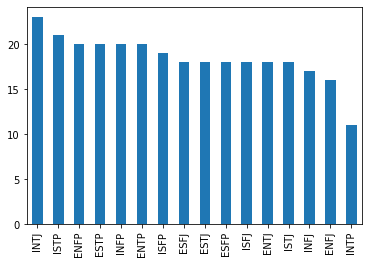

In [0]:
# Checking if there's any NaN value
isnull = [i for i in (new_df['descripcion'].isnull()) if i == True]
if isnull != []:
  print(isnull)
else:
  print(len(new_df['tipos'].value_counts()))
  print(f'\nCheck for NaNs:\n{new_df.isnull().any()}')
  print(new_df['tipos'].value_counts())

  new_df['tipos'].value_counts().plot(kind = 'bar')
  plt.show()  

---
# **4. Manipulating the data**
---

# **4.1. Stopwords NLTK & SpaCy**




**Specific stopwords list**

In [0]:
spec_stopwords = ['arquitecto', 'solo', 'persona', 'personalidad', 'tipo', 'punto', 'comandante',
                 'lógico', 'innovador', 'abogado', 'mediador', 'protagonista',
                 'activista', 'puede', 'debater', 'logista', 'defensor', 'ejecutivo',
                 'cónsul', 'virtuoso', 'aventurero', 'emprendedor', 'animador']

**Function to get rid of stopwords**

In [0]:
def get_stop_words(): 
  # Getting in a list all the stopwords of the dataframe with is_stop() from SpaCy
  spacy_stop_words = list(dict.fromkeys([str(i) for i in spNLP(' '.join([elem for elem in new_df['descripcion']])) if i.is_stop == True]))
  
  stop_words = stopwords.words('spanish') # defining the language
  stop_words.extend(spec_stopwords) # extending the specific stopwords
  stop_words.extend(spacy_stop_words) # extending the spacy stopwords
  stop_words = set(stop_words)
  return stop_words

stop_words = get_stop_words() # defining the stop_words set in a variable to better understanding whe applying on the dataframe

**Applying stopwords on the dataframe**



In [0]:
# Applying stopwords on the dataframe
new_df['descripcion'] = new_df['descripcion'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(new_df.iloc[3, 1])

gente grupo maravilloso rara sientan causa digna resuelto capacidad defensores relacionarse forma íntima rival introvertidos alegría experimentan relaciones mantener familia unida feliz regalo involucrados especialmente cómodos centro atención sentirse culpables ponerse medallas esfuerzos equipo aseguran esfuerzos reconocidos defensores propensos sentir nivel satisfacción tipos soñar apoyo defensores ayudantes universales comparten conocimiento experiencia energía cualquiera necesite amigos familiares personas esfuerzan situaciones ganarganar eligiendo empatía juicio


# **4.2. Lemmatization StandfordNLP**

**Function to lemmatize**

In [0]:
def stanford_lemma(text):
  doc = stNLP(text)
  return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

**Lemmatization and get rid of new stopwords**

In [0]:
# Lemmatization of dataframe
new_df['descripcion'] = new_df['descripcion'].apply(lambda x: stanford_lemma(x))

# Getting new stop_words after lemmatization (Lemmatizing: personalidades, personlidad = stopword)
get_stop_words()

# applying new stop_words on the dataframe
new_df['descripcion'] = new_df['descripcion'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in stop_words]))

**Checking if every stopword was removed**

In [0]:
# checking a specific stopword
for spec_word in spec_stopwords:
  check_spec_stopword = new_df['descripcion'].str.contains(spec_word, case=False).astype(int)
  check_zeros = [zero for zero in check_spec_stopword if zero != 0]
if check_zeros == []:
  print('Stopwords were applied correctly')
else:
  print(check_zeros)

Stopwords were applied correctly



# **4.3. Splitting the data into x and y**
spliting the data into x (description or train data) and y (labeles or personality types)

In [0]:
# Representing the DataFrame simply as data
data = new_df

# Getting the columns (tipos and descripcion) as strings into pandas.core.series.Series object.
(x_train, y_train) = (data.descripcion, data.tipos)

# Getting the columns as np.arrays
train_data_arr = np.array(list(x_train))
train_labels_arr = np.array(list(y_train))

# **4.4. Visualizing the data: Histogram and Word Cloud**

**Histogram function**

In [0]:
def histogram(text_arr, N = 100):
  text = ' '.join([str(elem) for elem in text_arr])

  words = text.split()
  counts = Counter(words)
  serie = pd.Series(counts) # convert dictionary to pandas Series object

  # sort the values (in ascending order) of the serie and select the N most frequent words
  first_N = serie.sort_values().tail(N) # similar to most_common but most efficient, because calculates the frecuencies just once.
  
  ax = first_N.plot.barh(figsize=(8, 16)) # make the horizontal bar plot, set the size of the figure
  i = 0
  xoffset = 0.1 # value to adjust the text label
  for v in first_N.values:
    # adds the text next to each bar
    ax.text(y=i, x=v + xoffset, s=v, ha='left', va='center') 
    i += 1

**Word Cloud function**

In [0]:
def word_cloud(text_arr):
  # Train data list to text
  train_data_text = ' '.join([str(elem) for elem in text_arr])

  # Create and generate a wordcloud image
  wordcloud_unclean = WordCloud(background_color="black").generate(train_data_text)

  # Display the generated image:
  plt.figure(figsize = (15, 10))
  plt.imshow(wordcloud_unclean, interpolation='bilinear')
  plt.axis("off")
  plt.show()

**Display: histogram & word cloud**

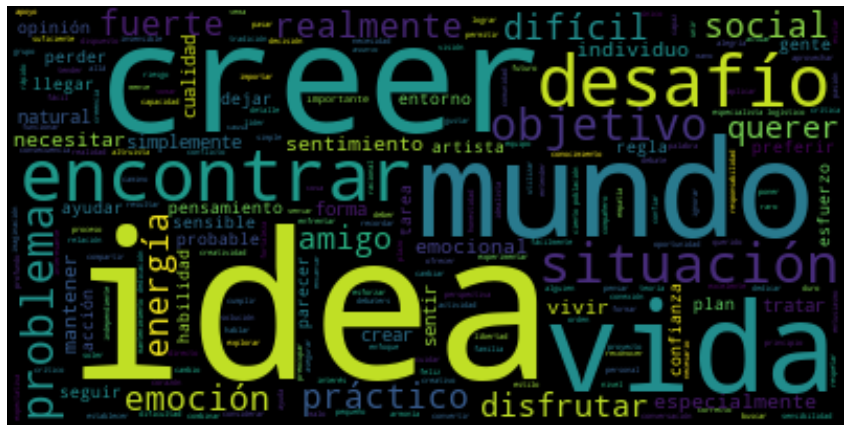

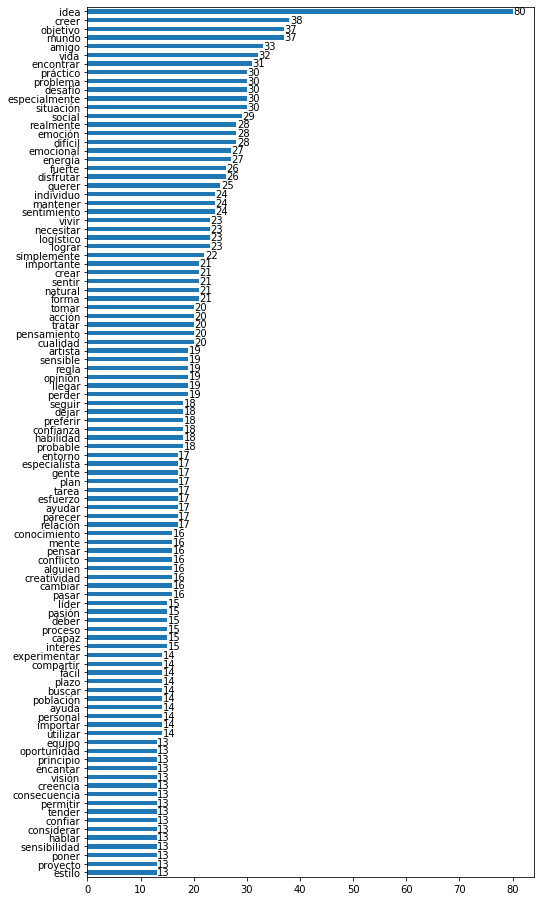

In [0]:
word_cloud(train_data_arr)
histogram(train_data_arr)

# **4.5. Assigning percentages to training & validation data**

In [0]:
# We assign of the train_data, 80% for training and 20% for validation 
train_size = int(len(train_data_arr) * 0.8) # 80%

# 0 to 80%
train_data = train_data_arr[:train_size]
train_labels = train_labels_arr[:train_size]

# 80% to end
val_data = train_data_arr[train_size:]
val_labels = train_labels_arr[train_size:]

print('\nReal size: TRAIN vs VALIDATION')
print(f'80% = {len(train_data)}  | 20% = {len(val_data)}')


Real size: TRAIN vs VALIDATION
80% = 236  | 20% = 59


---
# **5. Preprocessing the train_data**
---

# **5.1. Tokenization of train data:**

In [0]:
filter_char = '-{|*+}][<=>@^_~“”,.()\"/:#$%&;""%?¿!¡´`\u200b\n\r\t' # \u200b unicode unrecognised a space

`.fit_on_texts(texts)`: updates internal vocabulary based on a list of texts. In the case where texts contains lists, we assume each entry of the lists to be a token.

Required before using texts_to_sequences or texts_to_matrix.

In [0]:
# with OOV the tokenizer will create a token for words which does not recognize on the test_data (from the train data)
tokenizer = Tokenizer(num_words = 1916,
                      filters = filter_char,
                      lower = True,
                      split = ' ',
                      oov_token  = '<OOV>') 
# Tokenizer
tokenizer.fit_on_texts(train_data)

# Indexing each word from the tokenized x_train_data_array
word_index = tokenizer.word_index

# Reversing word index value:keys (1:palabra)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(reverse_word_index)

{1: '<OOV>', 2: 'idea', 3: 'creer', 4: 'objetivo', 5: 'mundo', 6: 'situación', 7: 'amigo', 8: 'realmente', 9: 'difícil', 10: 'problema', 11: 'especialmente', 12: 'emoción', 13: 'vida', 14: 'práctico', 15: 'desafío', 16: 'fuerte', 17: 'disfrutar', 18: 'mantener', 19: 'logístico', 20: 'social', 21: 'encontrar', 22: 'energía', 23: 'necesitar', 24: 'sentir', 25: 'simplemente', 26: 'individuo', 27: 'tratar', 28: 'crear', 29: 'vivir', 30: 'pensamiento', 31: 'confianza', 32: 'lograr', 33: 'querer', 34: 'sentimiento', 35: 'artista', 36: 'forma', 37: 'cualidad', 38: 'natural', 39: 'acción', 40: 'importante', 41: 'regla', 42: 'especialista', 43: 'plan', 44: 'emocional', 45: 'tomar', 46: 'habilidad', 47: 'ayudar', 48: 'llegar', 49: 'alguien', 50: 'relación', 51: 'esfuerzo', 52: 'opinión', 53: 'parecer', 54: 'perder', 55: 'cambiar', 56: 'gente', 57: 'probable', 58: 'proceso', 59: 'tarea', 60: 'ayuda', 61: 'seguir', 62: 'mente', 63: 'buscar', 64: 'sensible', 65: 'deber', 66: 'experimentar', 67: 'fá

# **5.2. Text to sequences**
After tokenization, the next step is to turn those tokens into lists of sequence.

In [0]:
train_data_sequences = tokenizer.texts_to_sequences(train_data)

# **5.3. Padding the train data**
When we train neural networks for NLP, we need sequences to be in the same size, that’s why we use padding.

In [0]:
train_data_padded = tf.keras.preprocessing.sequence.pad_sequences(
  train_data_sequences,
  maxlen = 240,
  dtype = 'int32',
  padding = 'post',
  truncating = 'post', # remove values from sequences larger than maxlen
  value = 0.0)

---
# **6. Preprocessing the validation_data**
---

# **6.1. Text to sequence & padding validation**

In [0]:
# Tokenization, validation text to sequences
validation_sequences = tokenizer.texts_to_sequences(val_data)

# Padding the validation data
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences,
                                                                  maxlen = 240,
                                                                  dtype = 'int32',
                                                                  padding = 'post',
                                                                  truncating = 'post',
                                                                  value = 0.0)

---
# **7. Preprocessing the labels: tokenization**
---

# **7.1. Tokenization train_labels**

In [0]:
# creating a new instace
label_tokenizer = Tokenizer()

# Tokenization:
# updates internal vocabulay based on a list of text
# each entry of into a list is assumed to be a token
# requiered before using text sequences
label_tokenizer.fit_on_texts(train_labels_arr)

In [0]:
train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(val_labels))

---
# **8. Analizing data before training**
---


# **8.1. Decode function: reverse_word_index** 
before training deep neural network, we should explore what our original text after padding look like.

In [0]:
def decode(data):
	""" decode the training and testing data into readable words"""
	return ' '.join([reverse_word_index.get(i, '<PAD>') for i in data]) # get index i, if we can't find a value for i, then we put ?

print(decode(train_data_padded[1]))
print(decode(validation_padded[1]))

reacio cambiar desafío particularmente difícil abordar defensora valorar tradición historia decisión situación necesitar llegar ruptura persuadido circunstancia fuerte querido cambiar rumbo <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

# **8.2. Analizing to debug**

In [0]:
print(f'''
LENGTH:
ITEM.
1. training padded: {len(train_data_padded[0])}
2. validation padded: {len(validation_padded[0])}

TENSOR.
1. training padded: {len(train_data_padded)}
2. validation padded: {len(validation_padded)}

SIZE:
ITEM.
1. training padded: {train_data_padded[0].size}
2. validation padded: {validation_padded[0].size}

TENSOR.
1. training padded: {train_data_padded.size}
2. validation padded: {validation_padded.size}


DIMENSIONS:
1. training padded: {train_data_padded.ndim}
2. validation padded: {validation_padded.ndim}

SHAPE:
1. training padded: {train_data_padded.shape}
2. validation padded: {validation_padded.shape}

''')



LENGTH:
ITEM.
1. training padded: 240
2. validation padded: 240

TENSOR.
1. training padded: 236
2. validation padded: 59

SIZE:
ITEM.
1. training padded: 240
2. validation padded: 240

TENSOR.
1. training padded: 56640
2. validation padded: 14160


DIMENSIONS:
1. training padded: 2
2. validation padded: 2

SHAPE:
1. training padded: (236, 240)
2. validation padded: (59, 240)




---
# **9. Creating the model: LSTM**
---

In [0]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1876


In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=240))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 240, 100)          187600    
_________________________________________________________________
flatten_3 (Flatten)          (None, 24000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               2400100   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 2,587,801
Trainable params: 2,587,801
Non-trainable params: 0
_________________________________________________________________


---
# **10. Training the model**
---

In [0]:
fitModel = model.fit(train_data_padded, train_label_seq,
					 epochs = 100,
					 batch_size = 295, #how many we will load it at once (number of samples per gradient) 295
					 validation_data = (validation_padded, validation_label_seq), #(x_val, y_val) validation_padded, validation_label_seq
					 verbose = 2)

Train on 236 samples, validate on 59 samples
Epoch 1/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 8/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 9/100
236/236 - 0s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 10/100
236/236 - 0s - 

In [0]:
results = model.evaluate(validation_padded, validation_label_seq)
predict = model.predict_classes(validation_padded[0:240])
print(decode(predict))

---
# **11. Graph of the trained model**
---

In [0]:
fitModel_dict = fitModel.history
acc = fitModel_dict['accuracy']
val_acc = fitModel_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 8))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim((0.5, 1)) #tupla
plt.show()

In [0]:
def plot_graphs(fitModel, string):
  plt.plot(fitModel.history[string])
  plt.plot(fitModel.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(fitModel, "accuracy")
plot_graphs(fitModel, "loss")

In [0]:
#results = model.evaluate(test_data_padded, test_labels)
#print(results)

---
# **12. Saving and loading the model**
---


In [0]:
# Save the model in binary data: able to read it in quickly and use the model to make predictions
model.save(path_root + 'model_mbti.h5', overwrite = True, include_optimizer = True) # .h5 extension to save models

# Loading the model
modelFile = keras.models.load_model(path_root + 'model_mbti.h5')